# Building AI for BlackJack Game

This notebook is for explorartion purposes. I keep this notebook as a journal.

- This idea has been started with a conversation that I have made with my nephew. He asked me if we could build an AI agent that plays the best moves for blackjack. After some arguing on the topic, we have agreed that it would be overkill to train a deep net. Hence there were already best posible moves avaible. However this table only keeps the best action to play in a total matrix of player and dealer. So we have agreed to at least to construct a q-value table via reinforcement learning. We are expecting to construct a q-value table that will consists of the best move to to make (Hit,Double,Stand) in percentages. Our intension is to keep it simple so we will not implement the full rrules of the game. We will consider Ace as 1 not 11. I've learned that this is called hard totals. The avaible best moves are as follows:

![Best Action Table](best_moves_in_hard_totals.jpeg)

- So our plan is to put the percentages of each action for each state. (Q-Values)
- We are also aware of [this](https://towardsdatascience.com/reinforcement-learning-solving-blackjack-5e31a7fb371f) page. We may check it out in the future. But for learning purposes I will check it out if I geet stuck of my own.

28.05.2020

- I start right away coding the environment, I need to remember my other projects. First I will copy my abstract methods here.
- So while checking my other [projects](https://github.com/hakanonal/geodashml) I need to decide the dimensions of the table. 
    - 1 dimension is for the playes's total card.
    - 1 dimension is for the dealers open card.
    - and one dimension is for the action. which is for simplicity Hit or Stand.
- So the shape of the table is (21,10,2)
- Ok very simple q-tabled agent has been completed.
- action space 0 is stand and 1 is hit
- Ok I am currentlly stuck at play method of environment class. I need to think thourgh how should construct reward. Since getting the hihgest number would not be promoted. But I need to give reward to get more that dealer.

31.05.2020

- I have started to read [this](https://towardsdatascience.com/reinforcement-learning-solving-blackjack-5e31a7fb371f)
- I have completed reding. My First note is that in conclusion the wins and lose counts are almost same. I need to underrstand the reward mecanism better to make comments on this. 
- Writer sugested 3 addtional improvements on his code which I bealive I can apply fitst two on them. 1-do more episodes, 2-try different learning and exploration rate.
- Writer implemented the ace or 1 succesfully. I will notte that for later use.
- I have also relized that writer structured tthe q-table as 2 dim array and first dim keeps tuple as index, which is very convinient to easily expand the features of the state paramters. So I have changes it
- In terrms of reward, this example did not updated the q-table in every action but collects all the actions in a list forr every 1 episode and then loops though backwards to update. Which I think I am going to use the same tactic here. 
- I will continue later to adapt to play actions till end of the game and calculate and update the reward afterwards for each episode.

01.06.2020

- I have continues on developing agent and environment
- I have also tested my first run and startd to correct the syntax and other types of error.
- I have seen that if I convert the q-table numpy array to dictionary I understant that I need to change the state into tuple.
- However tuple values can not be updated and state must be updated all the time. 
- So I have converted the state also to dictionary.
- It seems that I am on correct path. Now since I have converted q-table to dictionary I need to init all possible values. otherwise I get the key error.
- I have implemented a getq function to check if the key is exists when accesing the q-value, if there is no q value I initilize as 0.
- Dude it is unbeliavable fast did I somtething wrong?
- I am turning the beast on, trying different config parameters.
- However, my intension is to detaili debug if the logic is working correctlly.
- I have seen in the article that the q-table has been stored the file using the pickle module. So I also used that.

In [ ]:
import numpy as np
import random
import pickle


class agent:

    def __init__(self,discount,exploration_rate,decay_factor, learning_rate):
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = exploration_rate # Initial exploration rate
        self.decay_factor = decay_factor
        self.learning_rate = learning_rate
        self.q_table = {}
        
    def get_next_action(self, state):
        if random.random() < self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.random_action()
        else:
            return self.greedy_action(state)

    def greedy_action(self, state):
        return np.argmax(self.getQ(state))
    def random_action(self):
        return random.random() > 0.5

    def getQ(self,state):
        player_sum = state['player_sum']
        dealer_sum = state['dealer_sum']
        if (player_sum,dealer_sum) not in self.q_table:
            self.q_table[(player_sum,dealer_sum)] = [0,0]
        return self.q_table[(player_sum,dealer_sum)]

    def train(self, old_state, new_state, action, reward):
        
        old_state_prediction = self.getQ(old_state)[action]
        new_state_prediction = self.getQ(new_state)

        old_state_prediction = ((1-self.learning_rate) * old_state_prediction) + (self.learning_rate * (reward + self.discount * np.amax(new_state_prediction)))

        self.q_table[(old_state['player_sum'],old_state['dealer_sum'])][action] = old_state_prediction
        return old_state_prediction

    def update(self, old_state, new_state, action, reward):        
        reward = self.train(old_state, new_state, action, reward)
        self.exploration_rate *= self.decay_factor
        return reward

    def save(self, file="policy"):
        fw = open(file, 'wb')
        pickle.dump(self.q_table, fw)
        fw.close()

    def load(self, file="policy"):
        fr = open(file, 'rb')
        self.q_table = pickle.load(fr)
        fr.close()        


In [ ]:
import random

class environment:

    def __init__(self, config=None):

        self.config = config
        self.agent = agent(
            discount=self.config['discount'],
            exploration_rate=self.config['exploration_rate'],
            decay_factor=self.config['decay_factor'],
            learning_rate=self.config['learning_rate']
            )
        self.initGame()
        self.metrics = {
            'tot_win' : 0,
            'tot_draw' : 0,
            'tot_lose': 0,
        }

    def initGame(self):
        self.state = {'player_sum':0,'dealer_sum':0} 
        self.state['player_sum'] += self.hit()
        self.state['player_sum'] += self.hit()
        self.state['dealer_sum'] += self.hit()
        self.actions_played = []

    def start(self):
        for episode in range(1,self.config['episode']+1):
            self.initGame()
            #player turn
            while True:
                action_to_play = self.agent.get_next_action(self.state)
                new_state, ended = self.play(action_to_play)
                self.actions_played.append((self.state,new_state,action_to_play))
                self.debug1(episode,self.state,new_state,action_to_play)
                self.state = new_state
                if ended:
                    break

            #dealer turn
            while True:
                new_state, ended = self.playDealer()
                self.debug1(episode,self.state,new_state,-1)
                self.state = new_state
                if ended:
                    break

            #q-tatble update backpropogation
            reward = self.findWinner()
            if reward == 1:
                self.metrics['tot_win'] += 1
                self.metrics['avg_win'] = self.metrics['tot_win'] / episode
            if reward == 0:
                self.metrics['tot_draw'] += 1
                self.metrics['avg_draw'] = self.metrics['tot_draw'] / episode
            if reward == -1:
                self.metrics['tot_lose'] += 1
                self.metrics['avg_lose'] = self.metrics['tot_lose'] / episode
            for old_state,new_state,action in reversed(self.actions_played):
                new_reward = self.agent.update(old_state,new_state,action,reward)
                self.debug2(episode,old_state,new_state,action,reward,new_reward)
                reward = new_reward

    def hit(self):
        return random.randint(1,10)

    def play(self,action):
        new_state = self.state.copy()
        ended = False
        if action:
            new_state['player_sum'] += self.hit()
        else:
            ended = True
        if new_state['player_sum'] > 21:
            ended = True
        return new_state, ended
        
    def playDealer(self):
        new_state = self.state.copy()
        ended = False
        new_state['dealer_sum'] += self.hit()
        if new_state['dealer_sum'] >= 17:
            ended = True
        return new_state, ended
        
    def findWinner(self):
        # player 1 | draw 0 | dealer -1
        winner = 0
        if self.state['player_sum'] > 21:
            if self.state['dealer_sum'] > 21:
                winner = 0
            else:
                winner = -1
        else:
            if self.state['dealer_sum'] > 21:
                winner = 1
            else:
                if self.state['player_sum'] < self.state['dealer_sum']:
                    winner = -1
                elif self.state['player_sum'] > self.state['dealer_sum']:
                    winner = 1
                else:
                    winner = 0
        return winner
    
    def debug1(self,episode,old_state,new_state,action):
        if(self.config['debug']):
            print("%d = %s -> %s -> %s"%(episode,old_state,action,new_state))
            input("continue?")

    def debug2(self,episode,old_state,new_state,action,old_reward,new_reward):
        if(self.config['debug']):
            print("%d = %s -> %s -> %s | %s->%s"%(episode,old_state,action,new_state,old_reward,new_reward))
            input("continue?")


In [ ]:
config = {
    'discount': 0.95,
    'exploration_rate':0.9,
    'decay_factor':0.9999,
    'learning_rate':0.01,
    'episode':1000000,
    'debug' : 0,
}

e = environment(config=config)

In [ ]:
e.start()
e.agent.save()
e.metrics

01.06.2020

- let's plot tthe q-table and see it is going to be mean something. To do that I will add a method into agent class that converts the q-table dictionary to multi dim numpy array.
- Well I have converted the qtable into numpy array. I have omitted the values that is not being represented for valid total. Suprasinglly all values are zero. I need to debug better if rewarrding mechanism is working good.
- I have added a debug method to see turns plays and steps are working fine. it seems ok. I will heck reward calcıulation also.
- Ok I think I have found the problem, in backpropogation in every update instead of using the old_state I have always used the self.state whichnis the last state of the game which is wrong.
- When I trained this way I have increase the win rate tto 40%, On the other hand draw position is also increased
- When I plot the q-values I have a very non-meaningful graph. I need to fins a better way to present this data better.

In [ ]:
e.agent.load()
e.agent.q_table

In [ ]:
X = []
Y = []
Z = [] 
for state,alist in e.agent.q_table.items():
    if(state[0] > 21):
        continue
    if(state[1] > 10):
        continue
    X.append([state[0],alist[0]])
    X.append([state[0],alist[1]])
    Y.append([state[1],alist[0]])
    Y.append([state[1],alist[1]])
    Z.append([0,alist[0]])
    Z.append([1,alist[1]])

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z,cmap="Oranges")

02.06.2020

- I want to represent q-table nicelly. So today I am going to work on that. 
- To do that I am planing to create a different notebook just reads the policy file and shows the values nicelly. I can document it good so that everrybody can read and understand that document.
- I am leaving the above method just as is but I did not like it.
- Suprisinglly I did not find any convienient library to acomplish this. Best documented view is the matpltlib's one [here](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.table.html)
- I will give try some [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) dataframe
- yeah it did nott work the error message = "Must pass 2-d input"

In [ ]:
import pandas
import numpy as np

e.agent.load()
e.agent.q_table

d = np.zeros((22,11,2))
for state,alist in e.agent.q_table.items():
    if(state[0] > 21):
        continue
    if(state[1] > 10):
        continue
    d[state[0]][state[1]][0] = alist[0]
    d[state[0]][state[1]][1] = alist[1]

df = pandas.DataFrame(data=d)
df

- ok! I will also check wandb if there is any table view tools.
- there is a ttabşe view option documented well [here](https://docs.wandb.com/library/log#logging-text-tables). Let's give it a try!
- I did not understand but I got an error "The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()" and I do not see how to fix. I also could not find any feedback reagrding this error related to wandb.

In [ ]:
import numpy as np
import wandb

e.agent.load()
e.agent.q_table

d = np.zeros((22,11))
for state,alist in e.agent.q_table.items():
    if(state[0] > 21):
        continue
    if(state[1] > 10):
        continue
    #d[state[0]][state[1]][0] = alist[0]
    #d[state[0]][state[1]][1] = alist[1]
    d[state[0]][state[1]] = alist[0]

In [ ]:
columns = ["%d"%i for i in range(11)]
columns

In [ ]:


t = wandb.Table(data=d,columns=["%d"%i for i in range(11)])
wandb.log({"test-table":t})

- My last bullet is to manually nivelly print the 3d table. Since the table is fixed size it will not be complicated I prosume.
- I have comleted the widelly all table below.
- I am having problem with the negative value where negattive values has minus sign before the number which results to mis align the table.
- So I have checked to colorize the values and print all values as absolute value. [This](https://github.com/welbornprod/colr) page is very helpful
- I have prefered to use [this](https://i.stack.imgur.com/6otvY.png)
- Alright so simply for every column there is two values: first one is forr stand and the second one is for hit. positive value are green and negative one are red. the q-values are gives the likelihood to win or loose if you take that specific action.
- So I will put this code to another notebook. 
- Wait why we do not have any values on firrst row?

In [ ]:
import numpy as np

e.agent.load()
e.agent.q_table
_sign = lambda x: x and (1, -1)[x<0]

d = np.zeros((22,11,2))
for state,alist in e.agent.q_table.items():
    if(state[0] > 21):
        continue
    if(state[1] > 10):
        continue
    d[state[0]][state[1]][0] = alist[0]
    d[state[0]][state[1]][1] = alist[1]

print("---------------------------------------------------------------------------------------------------------------------------")
print("  |     1     |     2     |     3     |     4     |     5     |     6     |     7     |     8     |     9     |    10     |")
for i in range(1,22):
    print("%02d|"%i, end="")
    for j in range(1,11):
        if _sign(d[i][j][0]) == 1:
            print("\x1b[1;32;40m%05.2f\x1b[0m"%d[i][j][0],end="|")
        if _sign(d[i][j][0]) == -1:
            print("\x1b[1;31;40m%05.2f\x1b[0m"%abs(d[i][j][0]),end="|")
        if _sign(d[i][j][1]) == 1:
            print("\x1b[6;32;47m%05.2f\x1b[0m"%d[i][j][1],end="|")
        if _sign(d[i][j][1]) == -1:
            print("\x1b[6;31;47m%05.2f\x1b[0m"%abs(d[i][j][1]),end="|")
    print("")
print("---------------------------------------------------------------------------------------------------------------------------")

- Ok I think we are ready to move the classes into scripts implement wandb metrics.
- wandb metrics has been completed. You can watch the metrics from [here](https://app.wandb.ai/hakanonal/blackjack).
- [This](https://github.com/hakanonal/blackjack/blob/master/qtable.ipynb) page does not show the results beatifully. It is all wrapped. I am looking for a better way to present the data.
- And also sometimes table shows values that are very close to 0. you only recognize them negative or positive. It is better to convert them to percentages.
- I have started to deploy to cloud.


03.06.2020

- I have make the table view of the q-table better by using matplotlib. I have made the changes [here](https://github.com/hakanonal/blackjack/blob/master/qtable.ipynb)
- During trying to check if I did the plot correct I have relized that in some cases tthere may be 0 q-values in the table. This causes the terminal view not to print those values and I have also corrected the terminal view also to printt the zero values.

05.06.2020

- We have decided to implement the full rules. First I am looking how to add hard/soft totals at the same time. 
- I need to keep track if 1 is checked and it is usable or not. I have checked again [this](https://github.com/MJeremy2017/Reinforcement-Learning-Implementation/blob/7ef2f36e991141154d1bc0e9afd55d25d8b09238/BlackJack/blackjack_solution.py#L163) page to understand better.
- So also dealer is going to need to keep track if there is usable ace or not. However during initilizattion I can not keep that value in state. otherwise it is going to affect the agent's dicision, where that value is not important to agent to consider. It is not relevant. 

08.06.2020

- Ok I have completed the soft totals logic. And I have checked the q-table right away. Of cource the dimensions of the table has changed. But at first glance I have seen that all values under 12 are 0. And also there is no value for dealer hit and stand 1.
- I need 2 things to do:
    - I need to ignore S1 and H1 in the table and add S11 and H11 at the end.
    - Find a better way to represent hard and soft totals seperatelly.

- So I have relized that although I have implemented the soft totals in environment I have missed to updatte the dimensions of the q-table.
- So I have corrected the agent q-table dimensions. No I will work on display on [qtable.ipynb](qtable.ipynb) file
- I have completed the terminal view of the table. I am printing the table twice for has usabale ace or not 
- I have also corrected the matplotview
- I have also trained %40win agent. However the results are not very satisfying. most of that actions arre very close to one another. Means it is deciding radomly. 
- This shos either this game needs no intellagance because it is most of the time luck or I there is substential error in my code.
- All this code is developed under soft-total branch

In [3]:
import numpy as np
from environment import environment

config = {
    'discount': 0.95,
    'exploration_rate':0.5,
    'decay_factor':0.9999,
    'learning_rate':0.0001,
    'episode':10000,
    'debug' : 0,
}
os.environ['WANDB_MODE'] = 'dryrun'
e = environment(config=config)
e.agent.load()
e.agent.q_table

wandb: Wandb version 0.9.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{(17, 2, True): [-0.0001, -2.634408639056067e-06],
 (20, 11, True): [0.002099652033895223, 1.9400000000000002e-08],
 (17, 5, False): [-0.0035990611700477447, -0.0036892481044440385],
 (10, 5, False): [-0.0001, -7.396762388602764e-06],
 (11, 5, False): [-0.0001, -1.4242884254968787e-05],
 (17, 9, False): [-0.0039990359565775044, -0.003981438810420773],
 (15, 9, False): [-0.003499280096160397, -0.0036865999136769037],
 (14, 2, False): [-0.0029994732570771893, -0.003178832407494167],
 (10, 2, False): [-0.0001, -8.127479032404005e-07],
 (10, 9, False): [-0.0001, 2.2488031001589457e-07],
 (18, 3, False): [-0.001299670652798792, -0.0014971577870568358],
 (11, 3, False): [-0.0001, -3.0988120748372195e-06],
 (12, 3, False): [-0.0012998800071996979, -0.0012932069935385237],
 (14, 8, False): [-0.0027994606667166035, -0.00277565735572649],
 (23, 8, False): [0, 0],
 (21, 6, False): [0.0049992320758284825, 0],
 (19, 6, False): [0.004298514731492535, 0.0],
 (12, 6, False): [-0.0012999072047245905, -

12.06.2020

- With nephew We have decided that the results were accurate. It should have give different probaility outcome for the dealers upcard. But our outcome was mostlly same for all dealer outcome. When we were arguing about this, we concluded that it may be the probability of hitting the card 10 is 4 times bigger ina normal game. So we decided to implement this idea. 

In [10]:
import random

def hit():
    cards = [1,2,3,4,5,6,7,8,9,10,10,10,10]
    hit_index = random.randint(0,12)
    return cards[hit_index]

In [33]:
hit()

10

(array([ 793.,  782.,  748.,  750.,  787.,  774.,  759.,  777.,  817.,
        3012.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

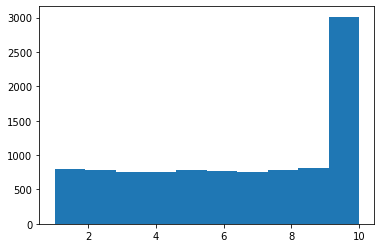

In [39]:
import matplotlib
import matplotlib.pyplot as plt

results = []
for i in range(1,10000):
    results.append(hit())

plt.hist(results)